# Multi-fidelity demo

In this notebook, we show how we can already obtain a good idea of where the best hyperparameters lie with low fidelity models.

Low fidelity models are those that would deliver a sub-optimal performance but at a much lower computational cost.

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
)

# the models to optimize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)

X_train = pd.DataFrame(breast_cancer_X)
y_train = pd.Series(breast_cancer_y).map({0:1, 1:0})

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y_train.value_counts() / len(y_train)

0    0.627417
1    0.372583
dtype: float64

## Multi-fidelity

### data size

In [4]:
# set up the model
svm_model = SVC(kernel='rbf', random_state=0)

# determine the hyperparameter space
# we will search over 2 hyperparameters for this demo

param_grid = dict(
    C = stats.loguniform(0.001, 100),
    gamma = stats.loguniform(0.001, 100),
)

In [5]:
# set up the search

search = RandomizedSearchCV(svm_model,
                            param_grid,
                            scoring='accuracy',
                            cv=2,
                            n_iter = 50,
                            random_state=10,
                            n_jobs=4,
                            refit=False,
                           )

Darker orange means better accuracy


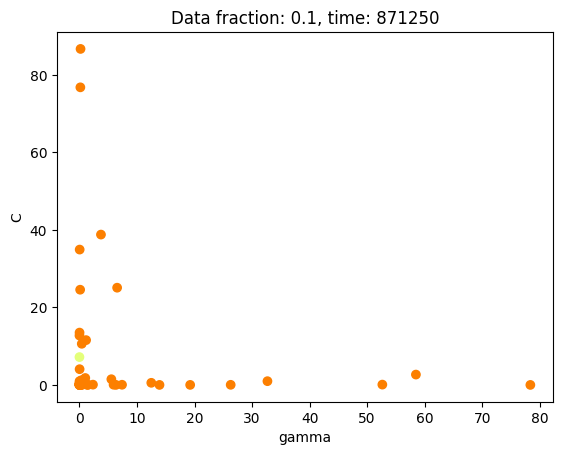

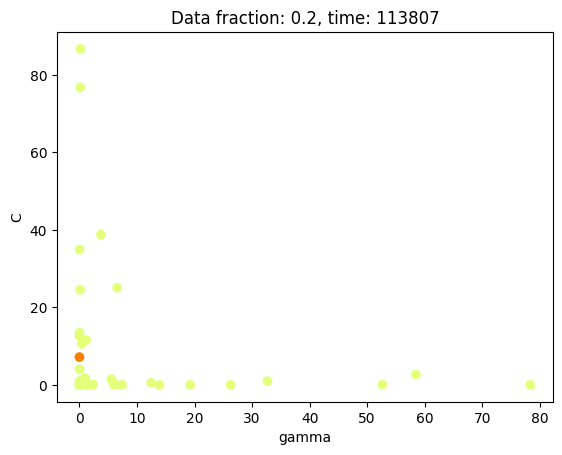

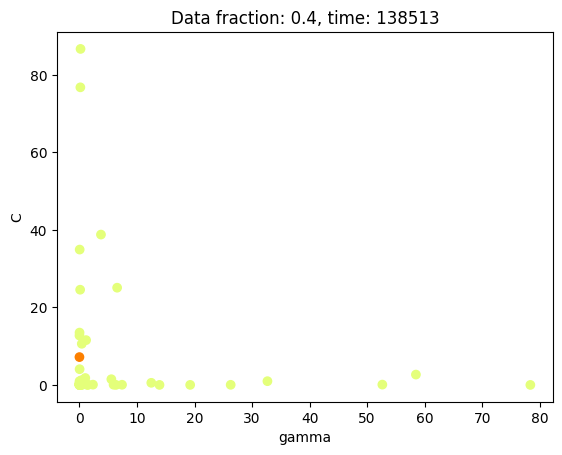

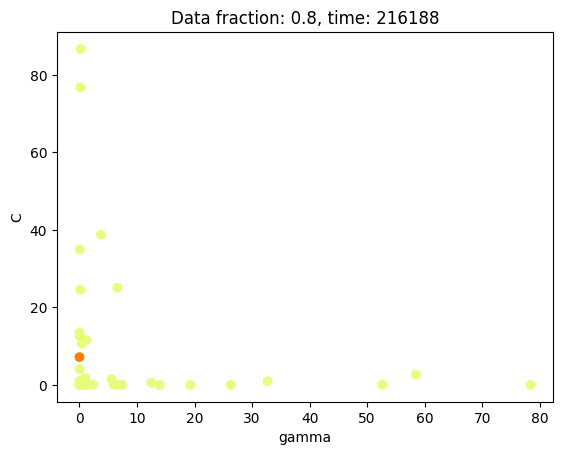

In [6]:
# determine the best hyperparameters and performance
# searching over datasets of different sizes
# that is, different fidelities

print('Darker orange means better accuracy')

for size in [0.1, 0.2, 0.4, 0.8]:

    # subsample the data
    n_samples = int(size * len(X_train))

    X_train_ = X_train.sample(n_samples, random_state=0)
    y_train_ = y_train[X_train_.index]

    # search
    ts = datetime.datetime.now()

    search.fit(X_train_, y_train_)

    td = (datetime.datetime.now()-ts).microseconds

    results = pd.DataFrame(search.cv_results_)

    # plot results
    plt.scatter(results['param_gamma'],
                results['param_C'],
                c=results['mean_test_score'],
                cmap='Wistia',
               )
    
    plt.title(f"Data fraction: {size}, time: {td}")
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.show()

For this particular dataset, utilizing 20% of the data already tells us where the best hyperparameter combination lies.

## number of estimators

In [7]:
# set up the model
rf = RandomForestClassifier(random_state=0)

# determine the hyperparameter space
# we will search over 2 hyperparameters for this demo

param_grid = dict(
    min_samples_split=stats.uniform(0, 1),
    max_depth=stats.randint(1, 5),
    )

In [9]:
# set up the search

search = RandomizedSearchCV(rf,
                            param_grid,
                            scoring='accuracy',
                            cv=2,
                            n_iter = 50,
                            random_state=10,
                            n_jobs=-1,
                            refit=False,
                           )

Darker orange means better accuracy


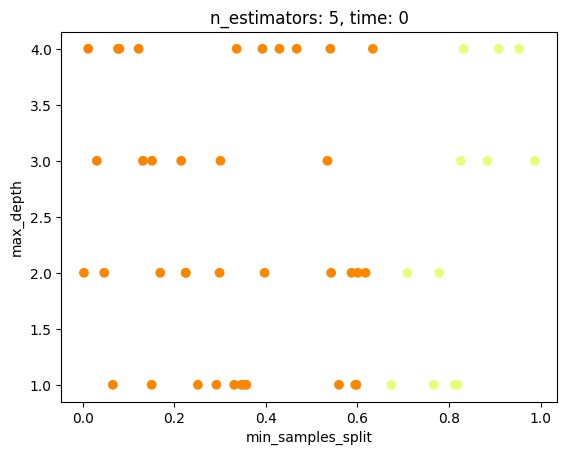

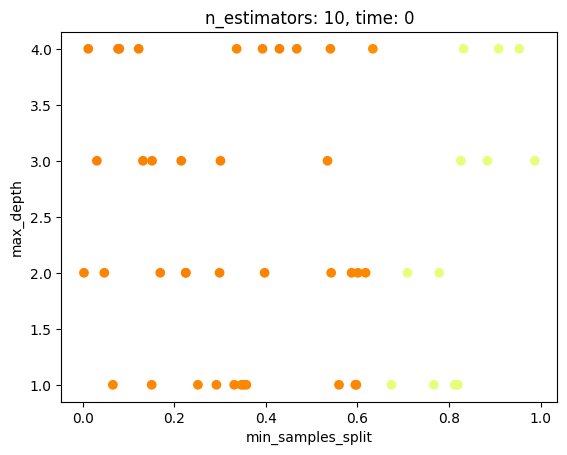

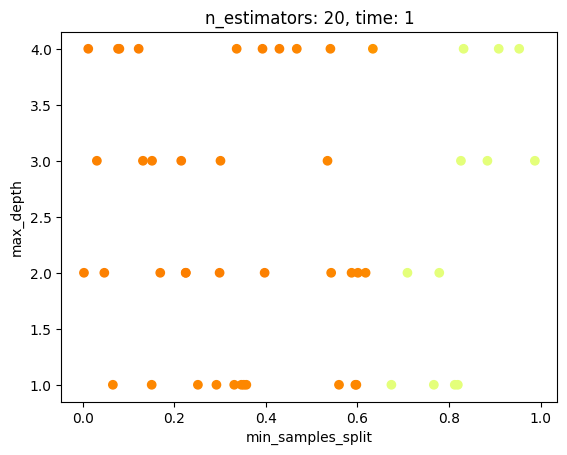

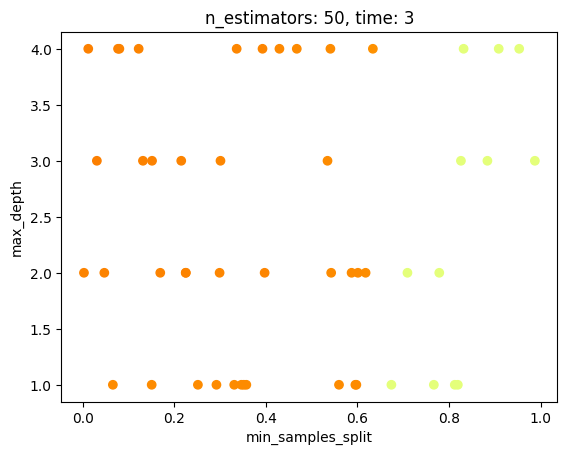

In [10]:
# determine the best hyperparameters and performance
# searching over models with different number of trees
# that is, different fidelities

print('Darker orange means better accuracy')

for n_estimators in [5, 10, 20, 50]:

    # fix the n_estimators parameter
    rf.set_params(**{'n_estimators': n_estimators})

    # search
    ts = datetime.datetime.now()

    search.fit(X_train, y_train)

    td = (datetime.datetime.now()-ts).seconds

    results = pd.DataFrame(search.cv_results_)

    # plot results
    plt.scatter(results['param_min_samples_split'],
                results['param_max_depth'],
                c=results['mean_test_score'],
                cmap='Wistia',
               )
    
    plt.title(f"n_estimators: {n_estimators}, time: {td}")
    plt.xlabel('min_samples_split')
    plt.ylabel('max_depth')
    plt.show()

We see that a random forest with 5 estimators, already tells us where the other hyperparameters best values are. 

For this particular example, if we use the number of estimators as the fidelity, then, we can't optimize this hyperparameter per se. But for the purpose of this demo, it helps us understand the different ways in which we can train lower fidelity algorithms.